#### This notebook, as the name suggests, is just for fun. It holds any interesting findings or any "aha" moments.

### 1. 
In the cells below you will see that the number of non-zeros in the matrix read from .mtx file is much larger than the number of lines (hence the number of edges) in the graph. What gives? 

Hint: See the ratio of count of non-zeros and number of edges! 

In [9]:
from scipy import io
import numpy as np

mtx_path = '..\data\socfb-American75.mtx'
mat = io.mmread(mtx_path)

print("number of vertices:", mat.shape[0])
print("percentage of non-zero elements in the matrix:", np.round(mat.count_nonzero()/np.prod(mat.shape)*100, 2))

number of vertices: 6386
percentage of non-zero elements in the matrix: 1.07


In [8]:
with open('../data/socfb-American75.edgelist') as file:
    lines = file.readlines()

print("number of edges in edgelist file =", len(lines), ", number of non-zero entries in matrix =", mat.count_nonzero())
print("Ratio of non-zero entries to number of edges =", mat.count_nonzero()/len(lines))

number of edges in edgelist file = 217662 , number of non-zero entries in matrix = 435324
Ratio of non-zero entries to number of edges = 2.0


#### Reason: The .mtx file with symmetric format stores only the entries on or below the main diagonal. So if you have an edge from node 1 to node 100, there would be entries at (1, 100) and (100, 1) in the matrix but only one edge in the mtx file to save space.

### 2.
Let's analyse the data now. For that I will use the processed data which I saved in 'data_prep.ipynb' to avoid writing all the code here again.

In [1]:
from tqdm.auto import tqdm
import pickle
import sys
import numpy as np

# read embeddings
emd_path = '../data/emb/socfb-American75.emd'
emd_map = {}
with open(emd_path, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        temp = line.split(' ')
        emd_map[np.int(temp[0])] = np.array(temp[1:], dtype=np.float)

# read the distances from landmarks
save_path = '../outputs/distance_map_socfb-American75_1590779864.8981035.pickle'
distance_map = pickle.load(open(save_path, 'rb'))

# form the training data: avg(emd_node1, emd_node2) -> distance
emd_dist_pair = []
for landmark in tqdm(list(distance_map.keys())):
    node_distances = distance_map[landmark]
    emd_dist_pair.extend([((emd_map[node]+emd_map[landmark])/2, distance) for node, distance in enumerate(node_distances, 1) if node != landmark and distance != np.inf])

print('length of embedding-distance pairs', len(emd_dist_pair))

# for numpy ndarray 
x = np.zeros((len(emd_dist_pair), len(emd_dist_pair[0][0])))
y = np.zeros((len(emd_dist_pair),))

for i, tup in enumerate(tqdm(emd_dist_pair)):
    x[i] = tup[0]
    y[i] = tup[1]
print("Shape of x={} and y={}".format(x.shape, y.shape))

100%|██████████| 948981/948981 [00:01<00:00, 641605.12it/s]Shape of x=(948981, 128) and y=(948981,)



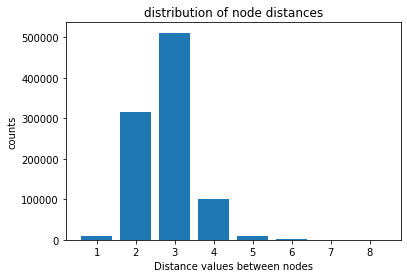

In [2]:
from matplotlib import pyplot as plt

values, counts = np.unique(y, return_counts=True)
plt.bar(values, counts, align='center')
plt.title('distribution of node distances')
plt.xlabel('Distance values between nodes')
plt.ylabel('counts')
plt.show()

So most of nodes have distance of 2 or 3 among them. This makes prediction hard, since model learns to predict 2.x values to minimize errors. Problem seems to be harder than I imagined.

### 4.
Why does path length '7' has such good prediction accuracy despite having small number of samples?

![path length wise accuracies](../outputs/path-wise-accuracies-run21.png "Path length wise accuracies")


As seen above, number of samples for path length 7 is very small (9) and after oversampling to large number of samples and training one would expect that the model would overfit on those samples and would not generalize well on test set. But we get the best accuracy on 7. It may be due to small number of nodes, even after stratified splitting, we have samples in train, validation, and test sets involing same nodes (different edges to and from same nodes), so network has trained on their feature embeddings already.

#### 5.
Average degree of the graph 'socfb-American75'. This should give us an idea of how complicated the graph is.

In [5]:
from scipy import io
import numpy as np

mtx_path = '..\data\socfb-American75.mtx'
mat = io.mmread(mtx_path).tocsr()
d_avg = round(mat.sum()/mat.shape[0], 2)
f'average degree of the graph is {d_avg}'

'average degree of the graph is 68.17'

#### 6.
Visualize the path embeddings on which we are training the NN. I will use the processed data saved by data_prep.ipynb for brevity.

In [1]:
import numpy as np
import pickle

data_path = '../outputs/train_xy_no_sampling_stdScale.pk'

# x holds combined embeddings nodeA and nodeB and y holds path length between them
x_train, y_train = pickle.load(open('../outputs/train_xy_no_sampling_stdScale.pk', 'rb'))

# filter embeddings by node distance, filter out 100 from each
emb_2 = x_train[y_train==2][1:1000:10]
emb_3 = x_train[y_train==3][1:1000:10]
emb_6 = x_train[y_train==6][1:500:5]

x = np.vstack((emb_2, emb_3, emb_6))
len(x)

300

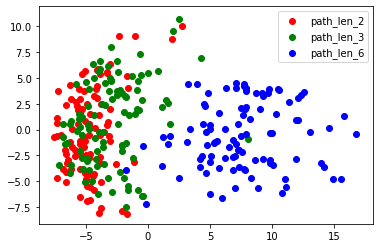

In [32]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
x = pca.fit_transform(x)

plt.scatter(x[:100, 0], x[:100, 1], c='r')
plt.scatter(x[100:200, 0], x[100:200, 1], c='g')
plt.scatter(x[200:300, 0], x[200:300, 1], c='b')
plt.legend(['path_len_2', 'path_len_3', 'path_len_6'])

plt.show()

The node pair embeddings combined by chosen binary operation (average in this case), can be seen forming clusters here. Embeddings for path length 2 and 3 pretty close to each other compared to embeddings for path length 6 (ignoring a few outliers in each cluster). This shows that embeddings have learned node features quite well. For you to further appreciate the quality of the features learnt by Node2Vec, I would stress here that these features were just learned to represent properties of a node, but simple binary operation on pair of nodes can capture distance information is just mind blowing! But as mentioned in the Node2Vec paper, the authors' intention was just this -- to learn features that represent both structural equivalence (role of a node in it's neighbourhood) and homophily (interconnectivity of nodes).<b> This also encourages us to try out clustering algorithms to predict distance.</b>

#### 7.
Graph visualization for fun. (This section is incomplete as I am still exploring graph visualization)

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy import io

mtx_path = '..\data\socfb-American75.mtx'
mat = io.mmread(mtx_path).tocsr()

np.random.seed(9999)
# data_path = '../outputs/train_xy_no_sampling_stdScale.pk'
# x_train, y_train = pickle.load(open('../outputs/train_xy_no_sampling_stdScale.pk', 'rb'))
emd_path = '../data/emb/socfb-American75.emd'
emd_map = {}
with open(emd_path, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        temp = line.split(' ')
        emd_map[np.int(temp[0])] = np.array(temp[1:], dtype=np.float)
# mask = np.random.randint(0, len(emd_map), 100)
x = np.array([emd_map[node] for node in emd_map])
sim_mat = cosine_similarity(x)
node1 = np.random.randint(0, len(emd_map))
# mask[(-mask).argsort()[:2][1]]
node2 = (-sim_mat[node1]).argsort()[:2][1]
print(f'node {node1} is most similar to node {node2}')

node 5802 is most similar to node 5720


In [2]:
print(f'degree of node {node1}={np.sum(mat[node1])} and node {node2} is {np.sum(mat[node2])}')

degree of node 5802=34.0 and node 5720 is 4.0


In [3]:
import networkx as nx
import numpy as np

edgelist_path = '../data/socfb-American75.edgelist'
graph = nx.read_edgelist(edgelist_path, nodetype=int)

In [5]:
# use this to visualize sub-graphs for node pairs with same distance, to see if they are similar.
nodes_to_be_visited = [node1, node2]
visited_nodes = []
while len(nodes_to_be_visited) > 0 and len(visited_nodes) < 100:
    node = nodes_to_be_visited.pop()
    visited_nodes.append(node)
    neigh = list(graph[node])
    # print(f'number of neighbours of node {node} is {len(neigh)}')
    for n in neigh:
        dist1 = nx.shortest_path_length(graph, node1, n)
        dist2 = nx.shortest_path_length(graph, node2, n)
        if(dist1 > 2 and dist2 > 2):
            continue
        if(n not in visited_nodes):
            nodes_to_be_visited.append(n)

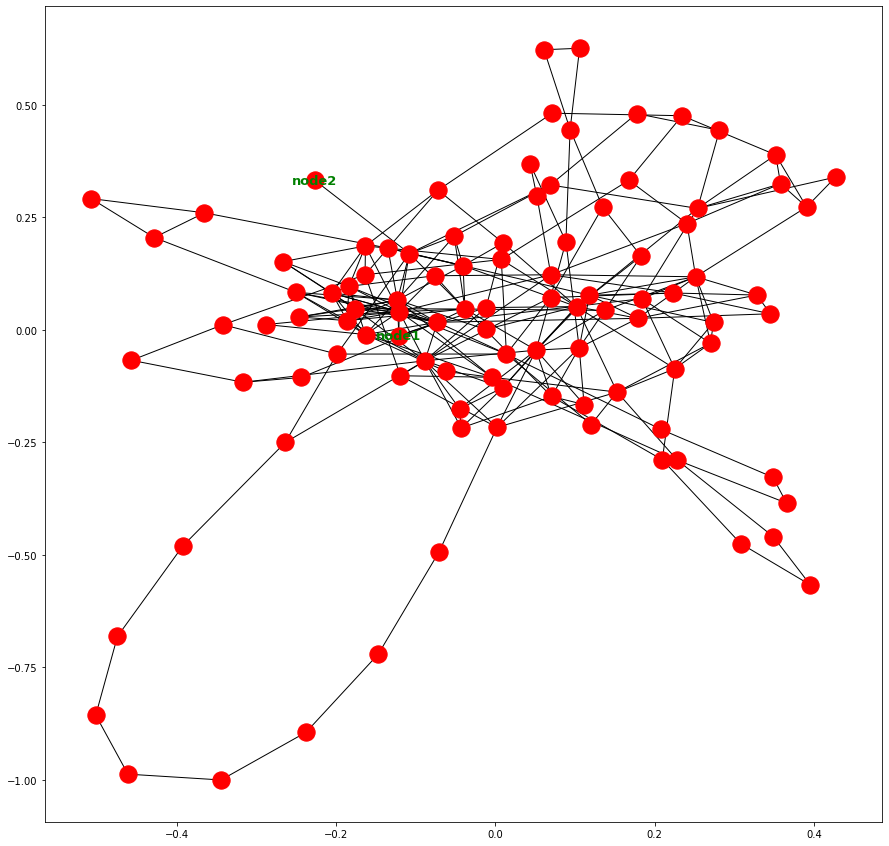

In [25]:
from matplotlib import pyplot as plt

# due to visited_nodes length check, we might have missed node1 and node2
visited_nodes.append(node1)
visited_nodes.append(node2)
sub_graph = graph.subgraph(visited_nodes)
pos = nx.spring_layout(sub_graph)
plt.figure(figsize=(15, 15))
labels = {node1: 'node1', node2: 'node2'}
sub_graph_nodes = list(sub_graph.nodes)
for node in visited_nodes:
    if node not in [node1, node2]:
        labels[node] = ''
nx.draw_networkx(sub_graph, with_labels=True, pos=pos, labels=labels, font_size=13, font_color='g', font_weight='bold')

False